In [1]:
# pre-sets
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle


main_folder = 'F:\YandexDisk\MonkeysDatas'
import os
os.chdir(main_folder + '/analysis')
import SpFun

data_folder = 'data_2'

# read protocol
filepath = main_folder + '/protocol/' + data_folder + '.xlsx'
protocol = pd.read_excel(filepath, sheet_name=0)
set_properties = pd.read_excel(filepath, sheet_name=1)
chosen_neuron_numbers = pd.read_excel(filepath, sheet_name=2)
neuron_names = protocol['neuron_name'].tolist()


# choose neurons
# 2 for all neurons
# 3 stable
case = 3
chosen_neurons = SpFun.GetNeuronNumbers(case, chosen_neuron_numbers)
chosen_neuron_names = SpFun.GetNeuronNames(case, chosen_neuron_numbers)
chosen_neurons_number = len(chosen_neurons)

#% setA stimuli names and ranges
set_names = set_properties['set names'].tolist()
shows_number = int(set_properties['shows number'][0])
pictures_number = int(set_properties['pictures number'][0])
stimuli_number = len(set_names)
neurons_number = len(protocol)

In [2]:
#%% convert dataset mat files into spike-trains(psths)

set_ranges = [];
for s in range(1,stimuli_number+1):
    set_ranges.append(list(range(1+pictures_number*(s-1), 1+pictures_number*s)))
    
# Whole dataset from mat files
dataset = SpFun.load_dataset_from_mat_files(main_folder + '/data', protocol)

# save Spike trains
SpFun.save_dataset_spike_trains(main_folder, data_folder, dataset, shows_number, pictures_number, set_ranges, set_names, protocol)

........

In [3]:
import pyspike as spk

def PsthToDirection(start_time, end_time, psth, chosen_neurons):
    trains = [];
    for picture_n in range(0,pictures_number):
        s_t = [];
        for show_n in range(0,shows_number):
            n_t = [];
            for neuron_n in chosen_neurons:# collecting all spike trains
                spike_train, silent_neuron = SpFun.spikeTrainFromInterval(start_time, end_time, picture_n, show_n, neuron_n, psth)
                n_t.append(spike_train)
            # direction of collected spike trains
            direction_l1 = spk.spike_directionality_matrix(n_t, max_tau = 25) #36x36
            s_t.append(direction_l1)
        trains.append(s_t)
    return np.asarray(trains)

In [4]:
def RespContDirections():
    control_direction = [];
    response_direction = [];
    for type_id in range(0,stimuli_number):
        psth = np.asarray(SpFun.loadSpikeTrain(folder_in, type_id))
      
        start_time = 400
        end_time = 500
        control_direction.append(PsthToDirection(start_time, end_time, psth,chosen_neurons))
        
        start_time = 600
        end_time = 900
        response_direction.append(PsthToDirection(start_time, end_time, psth,chosen_neurons))
    
    return np.asarray(response_direction), np.asarray(control_direction)

folder_in = main_folder + '/data/out/spike_trains/'+ data_folder + '/'
response_direction, control_direction = RespContDirections()
effect_direction = response_direction - control_direction;
np.shape(response_direction)

(8, 15, 20, 19, 19)

In [5]:
#%% save directions
def SaveDireсtions(directions, signal_part):
        #% save mean
        filepath = main_folder + '/data/out/direction/' + data_folder + '/' + signal_part + '_direction.pickle'
        with open(filepath, 'wb') as f:
            pickle.dump(directions, f)

SaveDireсtions(response_direction, 'response')
SaveDireсtions(control_direction, 'control')
SaveDireсtions(effect_direction, 'effect')

In [6]:
#%% load directions
def LoadDirections(signal_part, data_folder):
        #% save mean
        filepath = main_folder + '/data/out/direction/' + data_folder + '/' + signal_part + '_direction.pickle'
        with open(filepath, 'rb') as f:
            directions = pickle.load(f)
        return directions

In [7]:
average_response_direction = np.mean(response_direction, 2)
average_control_direction = np.mean(control_direction, 2)
average_effect_direction = average_response_direction - average_control_direction

np.shape(average_effect_direction)

(8, 15, 19, 19)

In [8]:
#%% make graphs

import mean_graphs
def NeuroGraph(average_direction, signal_part):
    for type_id in list(range(0,stimuli_number)):
        # make direction graph
        IndegrSet, OutdegrSet, G_set = mean_graphs.degrSet(average_direction[type_id],True, False)
        # save graph
        
        directory = main_folder + '/data/out/direction/' + signal_part +'/'+ data_folder +  '_graph/'
        if not os.path.exists(directory):
                os.mkdir(directory)
                
        filepath = directory + str(type_id) + '_' + set_names[type_id] + '_graph' + '.pickle'
        with open(filepath, 'wb') as f:
            pickle.dump(IndegrSet, f)
            pickle.dump(OutdegrSet, f)
            pickle.dump(G_set, f)
        print('mean direction graph for #' + str(type_id) + ' - ' + set_names[type_id] + ' is done')

# control graph
#NeuroGraph(average_control_direction, 'control')

# response graph
#NeuroGraph(average_response_direction, 'response')

# response vs control graph
# creating directory
signal_part = 'effect'
directory = main_folder + '/data/out/direction/' + signal_part
if not os.path.exists(directory):
    os.mkdir(directory)
    
NeuroGraph(average_effect_direction, 'effect')

mean direction graph for #0 - grooming is done
mean direction graph for #1 - agression is done
mean direction graph for #2 - monkey_play is done
mean direction graph for #3 - group is done
mean direction graph for #4 - mating is done
mean direction graph for #5 - baby_monkey is done
mean direction graph for #6 - animals_playing is done
mean direction graph for #7 - hiding is done


In [9]:
#%% collect degrees

def CollectDegrees(signal_part):
    all_indeg = []
    all_outdeg = []
    i = 0
    for type_id in list(range(0,stimuli_number)):
        filepath = main_folder + '/data/out/direction/' + signal_part +'/'+ data_folder +  '_graph/' + str(type_id) + '_' + set_names[type_id] + '_graph' + '.pickle'
        with open(filepath, 'rb') as f:
            IndegrSet = pickle.load(f)
            OutdegrSet = pickle.load(f)
            #G_set = pickle.load(f)
        if i == 0:
            Indeg = np.copy(np.mean(IndegrSet,0))
            Outdeg = np.copy(np.mean(OutdegrSet,0))
        else:
            Indeg = np.vstack([Indeg, np.mean(IndegrSet,0)])
            Outdeg = np.vstack([Outdeg, np.mean(OutdegrSet,0)])
        all_indeg.append(IndegrSet)
        all_outdeg.append(OutdegrSet)
        i+=1
    Indeg = np.transpose(np.mean(all_indeg, 1))
    Outdeg = np.transpose(np.mean(all_outdeg, 1))
    
    categories = []
    for i in range(0,stimuli_number):
        categories.append(set_names[i])
        
    return np.asarray(all_indeg), np.asarray(all_outdeg)
signal_part = 'effect'
indeg, outdeg = CollectDegrees(signal_part);

In [10]:
#%% save indeg outdeg
filepath = main_folder + "/data/out/direction/" + data_folder + "/degrees.pickle"

with open(filepath, 'wb') as f:
    pickle.dump(indeg, f)
    pickle.dump(outdeg, f)
    pickle.dump(chosen_neuron_names, f)

In [11]:
#%% load indeg outdeg
filepath = main_folder + "/data/out/direction/" + data_folder + "/degrees.pickle"

with open(filepath, 'rb') as f:
    indeg = pickle.load(f)
    outdeg = pickle.load(f)
    chosen_neuron_names = pickle.load(f)

Test for significant neurons (one-way ANOVA) 

In [12]:
#%% test for significant neurons (one-way ANOVA) 

chosen_types = list(range(0,len(set_names)))# all types

#% one-way kruskalwallis
import mean_graphs

p_values_indeg, stats_indeg = mean_graphs.neurons_kruskalwallis(indeg[chosen_types, :,:])
p_values_outdeg, stats_outdeg = mean_graphs.neurons_kruskalwallis(outdeg[chosen_types, :,:])

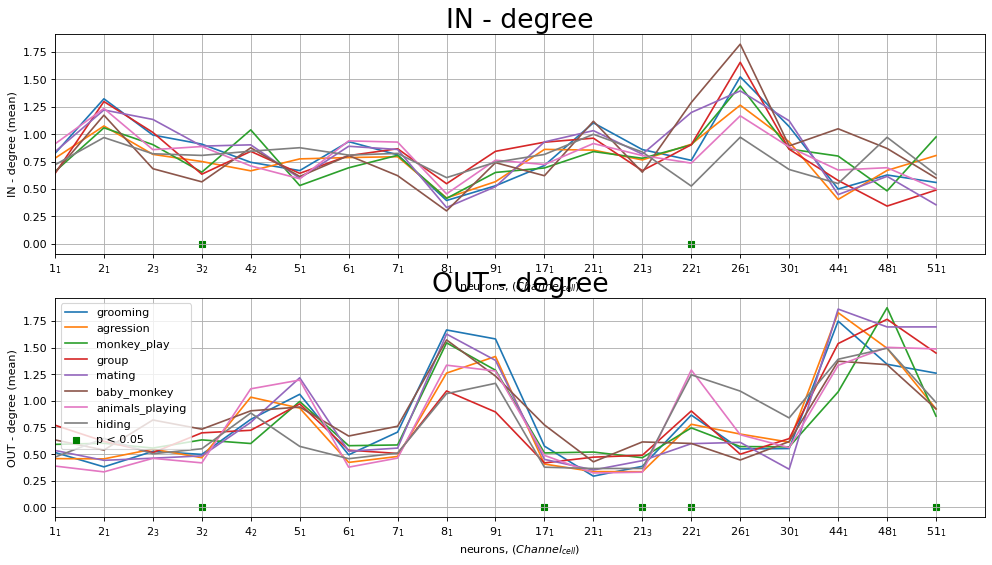

In [13]:
#%% threshold
# now only significant neurons are acounted

mode = 1
# mode 0 - Bonferroni
# mode 1 - alpha
alpha = 0.05
if mode == 0:
    threshold = alpha/(chosen_neurons_number*stimuli_number)# Bonferroni
    mode_text = 'Bonferroni'
if mode == 1:
    threshold = alpha
    mode_text = 'p = '+str(alpha)
    
correct_p_indeg = np.asarray(p_values_indeg) < threshold
correct_p_indeg_indx = np.squeeze(np.asarray(np.where(correct_p_indeg)))
mean_indeg = np.transpose(np.mean(indeg[chosen_types,:,:], 1))

correct_p = np.asarray(p_values_outdeg) < threshold
correct_p_outdeg_indx = np.squeeze(np.asarray(np.where(correct_p)))
mean_outdeg = np.transpose(np.mean(outdeg[chosen_types,:,:], 1))

# plot
chosen_set_names = [set_names[i] for i in chosen_types];
legend_names = chosen_set_names.copy()
legend_names.append('p < ' + str(threshold))
figure_title = 'one-way ANOVA'

x_neuron_names = [ '$' + neuron_names[i] + '$' for i in chosen_neurons]


plt.figure(dpi = 80, figsize = [15,8])
plt.subplot(211)
plt.title('IN - degree', fontsize = 24)
plt.plot(mean_indeg)
plt.scatter(correct_p_indeg_indx, 0 + np.zeros(np.size(correct_p_indeg_indx)),facecolor = 'g', marker="s")
plt.ylabel('IN - degree (mean)')
plt.grid('on')
plt.xlabel('neurons, ($Channel_{cell}$)')
plt.xticks(range(0,chosen_neurons_number,1), x_neuron_names);
plt.xlim([0, chosen_neurons_number])

plt.subplot(212)
plt.plot(mean_outdeg)
plt.title('OUT - degree', fontsize = 24)
plt.scatter(correct_p_outdeg_indx, 0 + np.zeros(np.size(correct_p_outdeg_indx)),facecolor = 'g', marker="s")
plt.legend(legend_names)
plt.ylabel('OUT - degree (mean)')
plt.grid('on')
plt.xlabel('neurons, ($Channel_{cell}$)')
plt.xticks(range(0,chosen_neurons_number,1), x_neuron_names);
plt.xlim([0, chosen_neurons_number])

#mngr = plt.get_current_fig_manager()
#mngr.window.setGeometry(0,0,1900,1000)

# common indexes
def MergeLists(first_list, second_list):
    result = first_list + list(set(second_list) - set(first_list))
    return result
common_neurons = MergeLists(list(correct_p_indeg_indx.flatten()),list(correct_p_outdeg_indx.flatten()))
common_neuron_names = [neuron_names[i] for i in common_neurons]

#%% save picture
pic_name = figure_title + ' '+mode_text
fname = main_folder + '/results/' + data_folder + '/' + pic_name + '.png'
plt.savefig(fname)

In [14]:
#%% save thresholded neurons
filepath = main_folder + "/data/out/direction/" + data_folder + "/thresholded_neurons.pickle"
with open(filepath, 'wb') as f:
    pickle.dump(correct_p_indeg_indx, f)
    pickle.dump(correct_p_outdeg_indx, f)
    pickle.dump(common_neurons, f)
    pickle.dump(threshold, f)

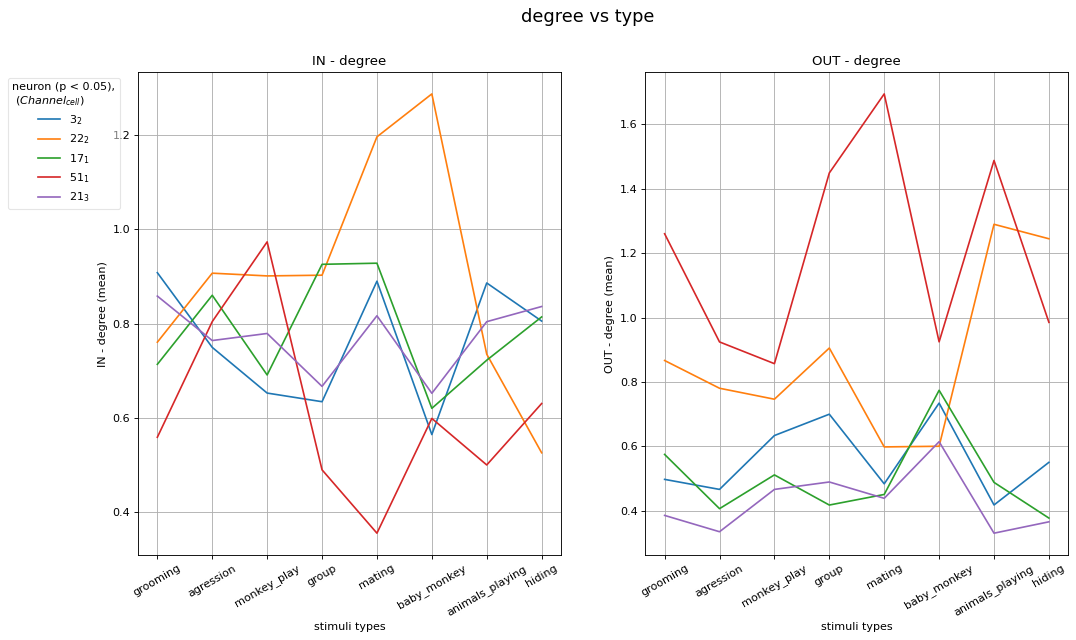

In [15]:
#%% degree vs type
mode = 2
# only after test
# indeg_indx = correct_p_indeg_indx
# outdeg_indx = correct_p_outdeg_indx

# all
# indeg_indx = list(range(0,11))
# outdeg_indx = list(range(0,11))

# common indexes: mode = 2
if mode == 2:
    indeg_indx = common_neurons
    outdeg_indx = common_neurons


n_vs_stim_indeg = np.transpose(mean_indeg[indeg_indx, :])
n_vs_stim_outdeg = np.transpose(mean_outdeg[outdeg_indx, :])
treshold_str = np.array2string(np.asarray(threshold), precision=2)
legend_title = 'neuron ('+ 'p < ' + treshold_str + '),\n ($Channel_{cell}$)'
figure_title = 'degree vs type'

plt.figure(dpi = 80, figsize = [15,8])
plt.suptitle(figure_title, fontsize=16)
plt.subplot(121)
plt.title('IN - degree')
plt.plot(n_vs_stim_indeg)
plt.ylabel('IN - degree (mean)')
plt.grid('on')
plt.xticks(range(len(chosen_set_names)), chosen_set_names, rotation=30);
plt.xlabel('stimuli types')
plt.legend(['$'+chosen_neuron_names[i]+'$' for i in indeg_indx], title=legend_title, framealpha=0.5,
           bbox_to_anchor=(-0.03, 1.00))

plt.subplot(122)
plt.plot(n_vs_stim_outdeg)
plt.title('OUT - degree')
plt.ylabel('OUT - degree (mean)')
plt.grid('on')
plt.xticks(range(len(chosen_set_names)), chosen_set_names, rotation=30);
plt.xlabel('stimuli types')
if mode != 2:
    plt.legend(['$'+chosen_neuron_names[i]+'$' for i in outdeg_indx], title=legend_title,
               bbox_to_anchor=(0.95, 1.00))

#mngr = plt.get_current_fig_manager()
#mngr.window.setGeometry(1,35,1500,800)
#%% save picture
pic_name = figure_title + ' '+mode_text
fname = main_folder + '/results/' + data_folder + '/'+ pic_name + '.png'
plt.savefig(fname)

In [16]:
#%% save all data to excel table
def reshape_3d_to_2d(img):
    new_img = img.reshape((img.shape[0]*img.shape[1]), img.shape[2])
    new_img = new_img.transpose()
    old_column_list = list(range(0,np.size(img, 0)))*np.size(img, 1)
    return new_img, old_column_list

def save_to_excel(all_outdeg, degree_dir, neuron_names):
    img = np.asarray(all_outdeg)
    [new_img, old_column_list] = reshape_3d_to_2d(img)
    to_save = pd.DataFrame(new_img, columns = old_column_list, index = neuron_names)
    
    for s in range(0, len(set_names)):
        to_save = to_save.rename(columns={s: set_names[s]})
    
    directory = main_folder + '/results/' + data_folder + '/'
    filepath = directory + data_folder + '_' + degree_dir + '-degrees.xlsx'
    to_save.to_excel(filepath)
    return to_save


saved_outdeg = save_to_excel(outdeg, 'stable neurons out', chosen_neuron_names)
saved_indeg = save_to_excel(indeg, 'stable neurons in', chosen_neuron_names)